In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf

In [2]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        stft = np.abs(librosa.stft(audio))
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T,axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio),
        sr=sample_rate).T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs,chroma,mel,contrast,tonnetz

In [3]:
fulldatasetpath = 'G:/urban_dataset/'

metadata = pd.read_csv(fulldatasetpath + '/metadata/UrbanSound8K.csv')

features = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    mfccs,chroma,mel,contrast,tonnetz = extract_features(file_name)
    features.append([mfccs,chroma,mel,contrast,tonnetz,class_label])

featuresdf = pd.DataFrame(features, columns=['mfccs','chroma','mel','contrast','tonnetz','class_label'])
#end = timeit.timeit()
#print("Time taken to extract features : ",end-start)
print('Finished feature extraction from ', len(featuresdf), ' files')

C:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Finished feature extraction from  8732  files


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
only_features=np.concatenate((featuresdf.mfccs.tolist(),featuresdf.chroma.tolist(),featuresdf.mel.tolist(),featuresdf.contrast.tolist(),featuresdf.tonnetz.tolist()),axis=1)
X = np.array(only_features)
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

train_x, test_x, train_y, test_y = train_test_split(X, yy, test_size=0.2, random_state = 42)

Using TensorFlow backend.


In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

In [6]:
# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim * 2
n_hidden_units_3 = 200 # half of layer 2

In [7]:
print(n_dim)
print("Features: {} Classes: {} ".format(n_dim, n_classes))

193
Features: 193 Classes: 10 


In [8]:
def create_model(activation_function='relu',init_type='normal', kernel_initializer="uniform", optimiser='Adamax', dropout_rate=0.5):
    model = Sequential()
    # layer 1
    #model.add(Convolution2D(n_hidden_units_1, input_dim=n_dim, activation=activation_function,kernel_initializer="uniform"))
    #model.add(MaxPooling2D(2,2))
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, kernel_initializer="uniform", activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, kernel_initializer="uniform" , activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, kernel_initializer="uniform", activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

In [9]:
model = create_model()
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

C:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 193)               37442     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               77600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 197,252
Trainable params: 197,252
Non-trainable params: 0
________________________________________________

In [11]:
history = model.fit(train_x, train_y, epochs=30, validation_split=0.1, callbacks=[earlystop], batch_size=24)

Train on 6286 samples, validate on 699 samples
Epoch 1/30
6286/6286 [==============================] - 6s 991us/step - loss: 1.9302 - acc: 0.3341 - val_loss: 1.4589 - val_acc: 0.4964
Epoch 2/30
6286/6286 [==============================] - 3s 432us/step - loss: 1.4402 - acc: 0.5005 - val_loss: 1.2435 - val_acc: 0.5751
Epoch 3/30
6286/6286 [==============================] - 3s 420us/step - loss: 1.2227 - acc: 0.5816 - val_loss: 1.0960 - val_acc: 0.6423
Epoch 4/30
6286/6286 [==============================] - 3s 449us/step - loss: 1.0821 - acc: 0.6357 - val_loss: 0.9547 - val_acc: 0.6710
Epoch 5/30
6286/6286 [==============================] - 3s 410us/step - loss: 0.9461 - acc: 0.6842 - val_loss: 0.8640 - val_acc: 0.7182
Epoch 6/30
6286/6286 [==============================] - 3s 404us/step - loss: 0.8364 - acc: 0.7227 - val_loss: 0.7600 - val_acc: 0.7639
Epoch 7/30
6286/6286 [==============================] - 3s 410us/step - loss: 0.7486 - acc: 0.7604 - val_loss: 0.7171 - val_acc: 0.7811
E

In [15]:
import keras
from matplotlib import pyplot as plt


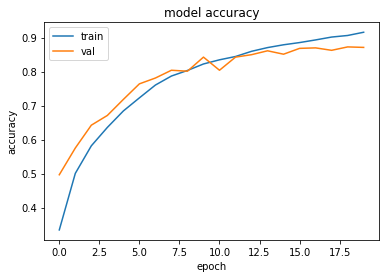

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

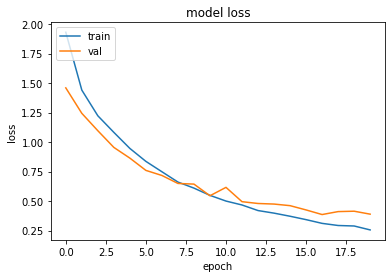

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [18]:
score, accuracy = model.evaluate(x = test_x, y = test_y , verbose = 1)

1747/1747 [==============================] - 0s 161us/step


In [19]:
print('ACCURACY:',accuracy,'\tSCORE:', score)

ACCURACY: 0.8855180311489597 	SCORE: 0.3645187386135135


In [20]:
model.save("NN_model.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('NN_model.h5')
# summarize model.
model.summary()
# load dataset

# evaluate the model
score = model.evaluate(x=test_x,y=test_y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 193)               37442     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               77600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 197,252
Trainable params: 197,252
Non-trainable params: 0
________________________________________________